/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/data.yaml
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/biodegradable85_jpg.rf.6927ffd36643b9f50920b796d9bee69e.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/cardboard893_jpg.rf.7a572bfa15b523f4edd3cc0f933422e0.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/biodegradable1027_jpg.rf.222d69e66b078b0988be66c23a22e16d.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/biodegradable472_jpg.rf.248b94449ec7c86e79c166aeb040a65a.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/cardboard1354_jpg.rf.f41c1cf9b4a78c3d9922eee5ce7cd158.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/cardboard847_jpg.rf.6dc31dc2203134005538fff0c506b477.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels/cardboard334_jpg.rf.4565b67c612d612cfd91886b8383553e.txt
/kaggle/input/garbage-detection/GARBAGE CLASSIF

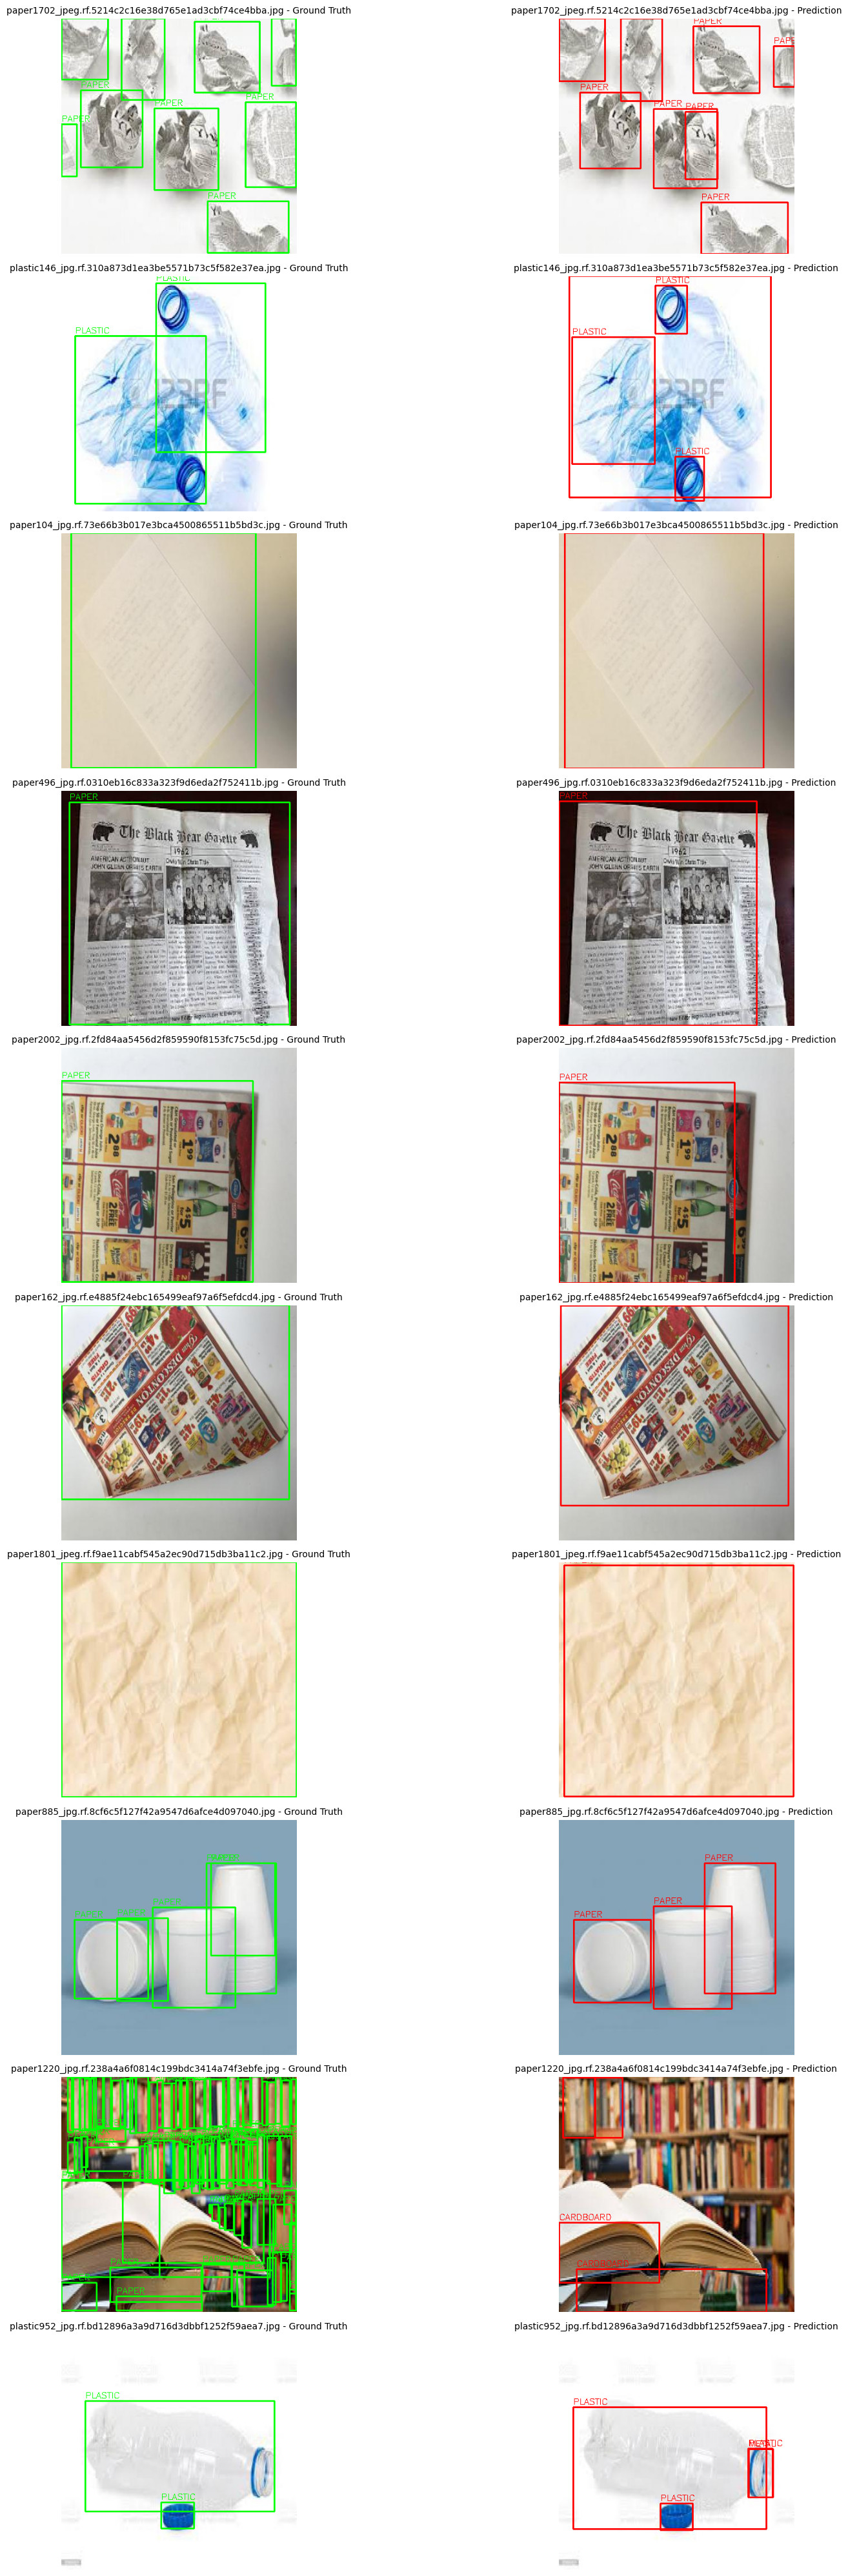

Your model is zipped and ready for download:


/kaggle/working/best_model_weights.zip

In [1]:
# Cell 1: Imports and Setup
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2, random
from PIL import Image
import os, shutil

# List input files (for Kaggle environment)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

# -----------------------------------------------------------------

# Cell 2: Define Paths
train_imgs_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/train/images"
val_imgs_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/images"
train_labels_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/train/labels"
val_labels_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/valid/labels"
root_dir = "/kaggle/working/data"

# -----------------------------------------------------------------

# Cell 3: Create YOLO Directory Structure
images_dir = os.path.join(root_dir, "images")
labels_dir = os.path.join(root_dir, "labels")

for split in ["train", "val"]:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# -----------------------------------------------------------------

# Cell 4: Copy Image and Label Files
shutil.copytree(train_imgs_dir, f"{root_dir}/images/train", dirs_exist_ok=True)
shutil.copytree(val_imgs_dir, f"{root_dir}/images/val", dirs_exist_ok=True)
shutil.copytree(train_labels_dir, f"{root_dir}/labels/train", dirs_exist_ok=True)
shutil.copytree(val_labels_dir, f"{root_dir}/labels/val", dirs_exist_ok=True)

# -----------------------------------------------------------------

# Cell 5: Create data.yaml file
# *** IMPORTANT: Corrected 'nc: 4' to 'nc: 6' to match the 6 class names. ***
data_yaml = f"""
train: {root_dir}/images/train
val: {root_dir}/images/val

nc: 6
names: ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']
"""

with open(f"{root_dir}/data.yaml", "w") as f:
    f.write(data_yaml)

# -----------------------------------------------------------------

# Cell 6: Train YOLOv5
# This command trains the model.
# The model weights are AUTOMATICALLY saved by this script.
# The best performing model will be saved as 'best.pt' inside the
# 'garbage_yolo/yolov5s_results/weights/' directory.
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 20 \
  --patience 20 \
  --data /kaggle/working/data/data.yaml \
  --weights yolov5s.pt \
  --project garbage_yolo \
  --name yolov5s_results \
  --exist-ok

# -----------------------------------------------------------------

# Cell 7: Evaluate the Trained Model
# This step uses the 'best.pt' file that was saved during training.
!python val.py \
  --img 640 \
  --batch 16 \
  --weights /kaggle/working/yolov5/garbage_yolo/yolov5s_results/weights/best.pt \
  --data /kaggle/working/data/data.yaml \
  --project /kaggle/working/eval

# -----------------------------------------------------------------

# Cell 8: Predict on Test Images
# This also uses the saved 'best.pt' model.
test_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/test/images"

!python detect.py \
  --weights "/kaggle/working/yolov5/garbage_yolo/yolov5s_results/weights/best.pt" \
  --source "$test_dir" \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --save-conf \
  --save-crop \
  --project /kaggle/working/test_preds \
  --name yolov5s_preds \
  --exist-ok

# -----------------------------------------------------------------

# Cell 9: Visualize Predictions
# Paths
test_images_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/test/images"
test_labels_dir = "/kaggle/input/garbage-detection/GARBAGE CLASSIFICATION/test/labels"
pred_labels_dir = "/kaggle/working/test_preds/yolov5s_preds/labels"
class_names = ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']

# Helper to draw boxes from YOLO format
def draw_boxes(image_path, label_path, color=(0, 255, 0), label_text=True):
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls_id = int(parts[0])
                x_center, y_center, box_w, box_h = map(float, parts[1:5])
                
                # Convert YOLO to pixel coords
                x1 = int((x_center - box_w / 2) * w)
                y1 = int((y_center - box_h / 2) * h)
                x2 = int((x_center + box_w / 2) * w)
                y2 = int((y_center + box_h / 2) * h)

                cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                if label_text:
                    label = class_names[cls_id]
                    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

# List of image filenames
image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.png'))]
sample_images = random.sample(image_files, 10) # Sample 10 images

# Plotting
plt.figure(figsize=(20, 40))
for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(test_images_dir, img_file)
    label_file = img_file.rsplit('.', 1)[0] + ".txt"

    gt_label_path = os.path.join(test_labels_dir, label_file)
    pred_label_path = os.path.join(pred_labels_dir, label_file)

    gt_img = draw_boxes(img_path, gt_label_path, color=(0, 255, 0))  # Green: GT
    pred_img = draw_boxes(img_path, pred_label_path, color=(0, 0, 255))  # Red: Pred

    # Convert BGR to RGB for matplotlib
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    plt.subplot(10, 2, idx*2 + 1)
    plt.imshow(gt_img)
    plt.title(f"{img_file} - Ground Truth", fontsize=10)
    plt.axis('off')

    plt.subplot(10, 2, idx*2 + 2)
    plt.imshow(pred_img)
    plt.title(f"{img_file} - Prediction", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------

# Cell 10: Save and Download the Model File
# This is the "save model" part you asked for.
# It takes the 'best.pt' file saved from training (Cell 6) 
# and packages it into a .zip file for you to download.
from IPython.display import FileLink

# Zip the directory containing best.pt
shutil.make_archive('/kaggle/working/best_model_weights', 
                    'zip', 
                    '/kaggle/working/yolov5/garbage_yolo/yolov5s_results/weights')

# Create a download link for the zip file
print("Your model is zipped and ready for download:")
FileLink("/kaggle/working/best_model_weights.zip")